# UNET (Ours)

Install the required libraries

In [1]:
!pip install torchgeometry

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 232 kB/s 


Download the dataset

In [4]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1OwK-wAmygNZ5sxF8T63mTG6EvLdRi0lV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1OwK-wAmygNZ5sxF8T63mTG6EvLdRi0lV
To: /content/nyu_data.zip
100% 4.40G/4.40G [01:15<00:00, 57.9MB/s]


In [9]:
!unzip -q nyu_data.zip

Import the required modules

In [5]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
from PIL import Image
from io import BytesIO
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchgeometry.losses import SSIM
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn

Define the Dataset

In [6]:
class DepthDataset(Dataset):
    def __init__(self, file_path, samples=1000):
        super(DepthDataset, self).__init__()
        self.data_list = pd.read_csv(file_path, header=None).sample(samples)

    def __getitem__(self, idx):
        image_path = self.data_list.iloc[idx, 0]
        depth_path = self.data_list.iloc[idx, 1]
        image = Image.open(image_path)
        mask = Image.open(depth_path)

        image = TF.resize(image, 480)
        mask = TF.resize(mask, 480)

        H, W = image.size

        if H % 16 != 0:
          H = H-H%16
        if W % 16 != 0:
          W = W-W%16

        image = TF.resize(image, (H, W))
        mask = TF.resize(mask, (H, W))

        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        return image, mask

    def __len__(self):
        return len(self.data_list)

Load the datasets in the loaders

In [10]:
train_set = DepthDataset("/content/data/nyu2_train.csv", samples=1000)
val_set = DepthDataset('/content/data/nyu2_test.csv', samples=100)

train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True)

Define the model

In [11]:
import torch
import torch.nn as nn


class DepthUnet(nn.Module):
  def __init__(self):
    super(DepthUnet, self).__init__()
    # Define the encoder layers
    self.enc1 = nn.Conv2d(3, 64, 3, padding=1)
    self.enc2 = nn.Conv2d(64, 64, 3, padding=1)
    self.enc3 = nn.Conv2d(64, 128, 3, padding=1)
    self.enc4 = nn.Conv2d(128, 128, 3, padding=1)
    self.pool = nn.MaxPool2d(2)

    # Define the decoder layers
    self.dec1 = nn.Conv2d(256, 128, 3, padding=1)
    self.dec2 = nn.Conv2d(192, 128, 3, padding=1)
    self.dec3 = nn.Conv2d(192, 64, 3, padding=1)
    self.dec4 = nn.Conv2d(67, 3, 3, padding=1)

  def forward(self, x):
    # Encode the input image
    enc1 = F.relu(self.pool(self.enc1(x)))
    enc2 = F.relu(self.pool(self.enc2(enc1)))
    enc3 = F.relu(self.pool(self.enc3(enc2)))
    enc4 = F.relu(self.pool(self.enc4(enc3)))


    upsample1 = nn.functional.interpolate(enc4, scale_factor=2, mode='bilinear')
    dec1 = self.dec1(torch.cat((upsample1, enc3), dim=1))
    upsample2 = nn.functional.interpolate(dec1, scale_factor=2, mode='bilinear')
    dec2 = self.dec2(torch.cat((upsample2, enc2), dim=1))
    upsample3 = nn.functional.interpolate(dec2, scale_factor=2, mode='bilinear')
    dec3 = self.dec3(torch.cat((upsample3, enc1), dim=1))
    upsample4 = nn.functional.interpolate(dec3, scale_factor=2, mode='bilinear')
    dec4 = self.dec4(torch.cat((upsample4, x), dim=1))

    # Return the final decoded image
    return dec4

Loss: SSIM (Structural Similarity Loss)

In [12]:
from torch.nn import MSELoss
# criterion1 = L1Loss()

In [13]:
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model will train on {device}")
model = DepthUnet()

Model will train on cuda


In [14]:
def scale_invariant_loss(y_true, y_pred):
    y_true_sum = torch.sum(y_true)
    y_pred_sum = torch.sum(y_pred)

    y_true_squared_sum = torch.sum(y_true ** 2)
    y_pred_squared_sum = torch.sum(y_pred ** 2)

    num = y_true_sum * y_pred_sum
    den = y_true_squared_sum * y_pred_squared_sum

    return num / den

In [15]:
# criterion = torch.nn.HuberLoss()
# criterion = torch.nn.L1Loss()

In [16]:
optimizer = Adam(model.parameters(), lr=1e-3)
# optimizer = Adam(model.parameters(), lr=0.01, momentum=0.99)
# scheduler = ReduceLROnPlateau(optimizer, mode='min')
loss_func1 = MSELoss()
loss_func2 = torch.nn.L1Loss()

model = model.to(device)

In [17]:
model = model.to(device)

Model Training

In [18]:
def dice_loss_with_sigmoid(sigmoid, targets, smooth=1.0):
	"""
  Works
	sigmoid: (torch.float32)  shape (N, 1, H, W)
	targets: (torch.float32) shape (N, H, W), value {0,1}
	"""
	outputs = torch.squeeze(sigmoid, dim=1)

	inter = outputs * targets
	dice = 1 - ((2*inter.sum(dim=(1,2)) + smooth) / (outputs.sum(dim=(1,2))+targets.sum(dim=(1,2)) + smooth))
	dice = dice.mean()
	return dice

In [19]:
num_epochs = 10
# optimizer = torch.optim.SGD(model.parameters())
training_losses = []
testing_losses = []
best_losses = [float('inf'), float('inf')]
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):

        total_training_loss = 0
        total_validation_loss = 0
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss1 = loss_func1(outputs, labels)
        loss2 = loss_func2(outputs, labels)
        loss = 0.9*loss1+0.1*loss2
        loss.backward()
        optimizer.step()
        total_training_loss+=loss.item()
        running_loss += loss.item()
        if i % 200 == 199:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

    with torch.no_grad():
        # model.eval()
        for i, data in enumerate(val_loader):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss1 = loss_func1(outputs, labels)
            loss2 = loss_func2(outputs, labels)
            loss = 0.9*loss1+0.1*loss2
            running_loss += loss.item()
            total_validation_loss += loss.item()
            if i % 100 == 0:    
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0
    avg_training_loss = total_training_loss / len(train_set)
    avg_validation_loss = total_validation_loss / len(val_set) 

    if avg_training_loss < best_losses[0] or avg_validation_loss < best_losses[1]:
        best_losses = [avg_training_loss, avg_validation_loss]
        torch.save(model.state_dict(), "best_model.pth")


    training_losses.append(avg_training_loss)
    testing_losses.append(avg_validation_loss)

    print(f'Total training loss: {total_training_loss:.5f}, Total Validation Loss: {total_validation_loss:.5f}')  

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1, 640, 480])) that is different to the input size (torch.Size([1, 3, 640, 480])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1, 1, 640, 480])) that is different to the input size (torch.Size([1, 3, 640, 480])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


[1,   200] loss: 0.037
[1,   400] loss: 0.035
[1,   600] loss: 0.035
[1,   800] loss: 0.033
[1,  1000] loss: 0.035
[1,     1] loss: 33718.348
Total training loss: 0.02157, Total Validation Loss: 737545071.00000
[2,   200] loss: 0.034
[2,   400] loss: 0.034
[2,   600] loss: 0.033
[2,   800] loss: 0.037
[2,  1000] loss: 0.035
[2,     1] loss: 38984.762
Total training loss: 0.02139, Total Validation Loss: 737498069.25000
[3,   200] loss: 0.038
[3,   400] loss: 0.035
[3,   600] loss: 0.032
[3,   800] loss: 0.030
[3,  1000] loss: 0.035
[3,     1] loss: 82862.000
Total training loss: 0.01186, Total Validation Loss: 737493264.87500
[4,   200] loss: 0.033
[4,   400] loss: 0.033
[4,   600] loss: 0.032
[4,   800] loss: 0.035
[4,  1000] loss: 0.034
[4,     1] loss: 63333.380
Total training loss: 0.07365, Total Validation Loss: 737511123.87500
[5,   200] loss: 0.034
[5,   400] loss: 0.036
[5,   600] loss: 0.033
[5,   800] loss: 0.031
[5,  1000] loss: 0.034
[5,     1] loss: 26336.040
Total training

Prediction

In [20]:
input_image, output_image = next(iter(train_loader))

In [21]:
model.to('cpu')
model_output = model(input_image)

In [22]:
model_output = model_output[0][0].detach().numpy()

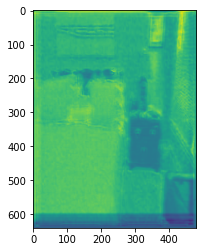

In [23]:
import matplotlib.pyplot as plt

plt.imshow(model_output)
plt.show()

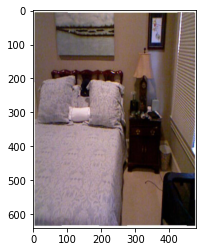

In [24]:
plt.imshow(input_image[0].permute(1, 2, 0))

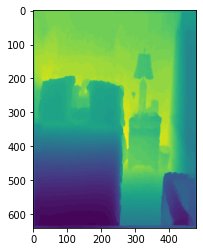

In [25]:
plt.imshow(output_image[0][0])

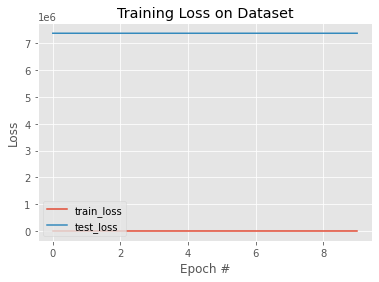

In [26]:
plt.style.use("ggplot")
plt.figure()
training_losses_cpu = [x for x in training_losses]
testing_losses_cpu = [x for x in testing_losses]
plt.plot(training_losses_cpu, label="train_loss")
plt.plot(testing_losses_cpu, label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("losses.jpg")

# serialize the model to disk
# torch.save(model, "model.pth")

In [27]:
from google.colab import files
files.download('best_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

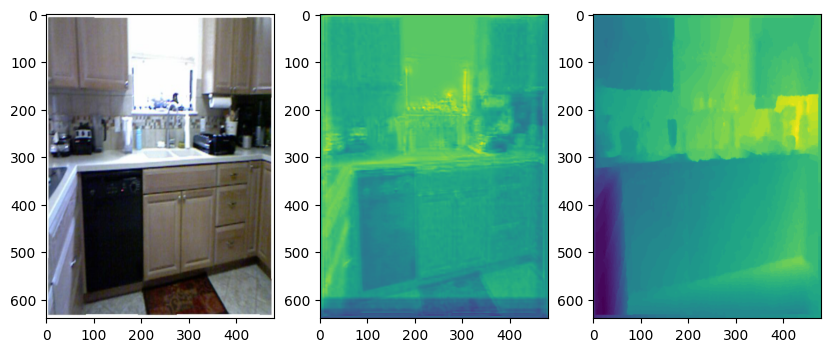

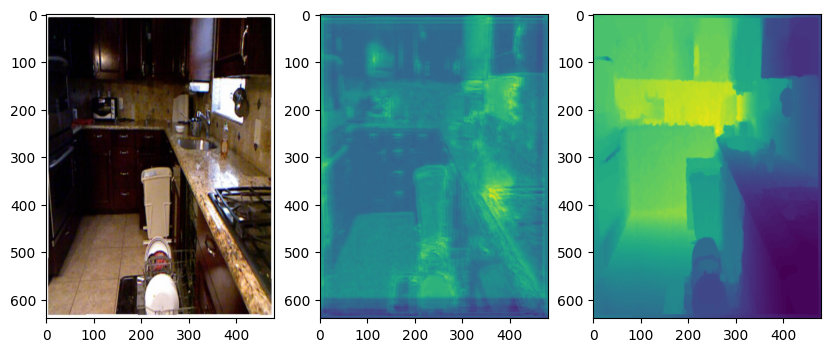

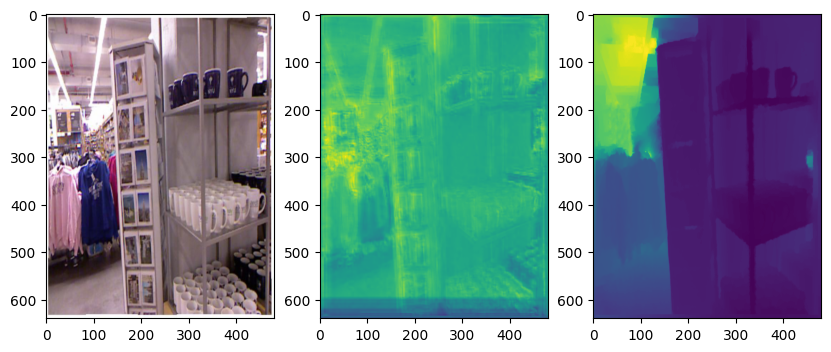

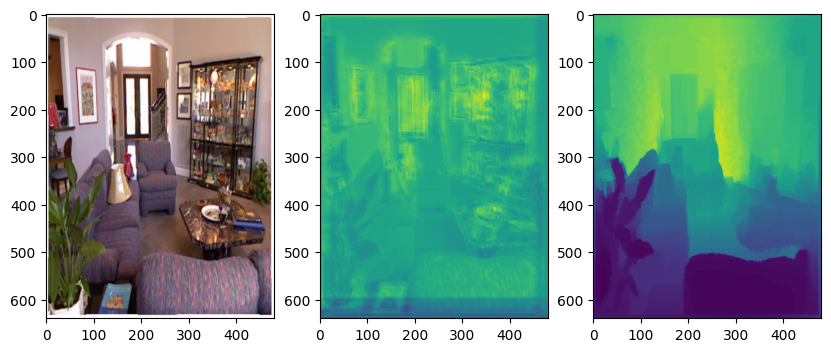

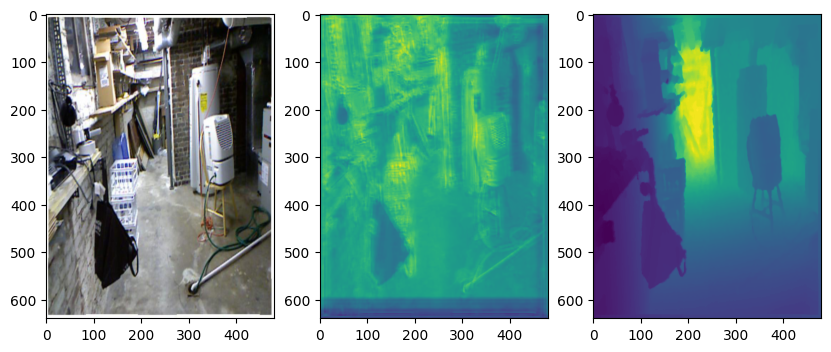

In [32]:
best_model = DepthUnet()

best_model.load_state_dict(torch.load("best_model.pth"))
plt.style.use("default")

count = 0
for input, label in train_loader:
  output = model(input)
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 3, 1)
  plt.imshow(input[0].permute(1, 2, 0))
  plt.subplot(1, 3, 2)
  plt.imshow(output[0][0].detach().numpy())
  plt.subplot(1, 3, 3)
  plt.imshow(label[0][0])
  plt.show()
  count+=1
  if count==5:
    break